In [38]:
import pandas as pd
import numpy as np
import seaborn as sns

from explorer import Explorer

In [39]:
train_df = pd.read_csv('./data/s4e5/train.csv')
test_df = pd.read_csv('./data/s4e5/test.csv')

Data Types of Variables:
----------------------------------------------------------------------------------------------------
id                                   int64
MonsoonIntensity                     int64
TopographyDrainage                   int64
RiverManagement                      int64
Deforestation                        int64
Urbanization                         int64
ClimateChange                        int64
DamsQuality                          int64
Siltation                            int64
AgriculturalPractices                int64
Encroachments                        int64
IneffectiveDisasterPreparedness      int64
DrainageSystems                      int64
CoastalVulnerability                 int64
Landslides                           int64
Watersheds                           int64
DeterioratingInfrastructure          int64
PopulationScore                      int64
WetlandLoss                          int64
InadequatePlanning                   int64
PoliticalFacto

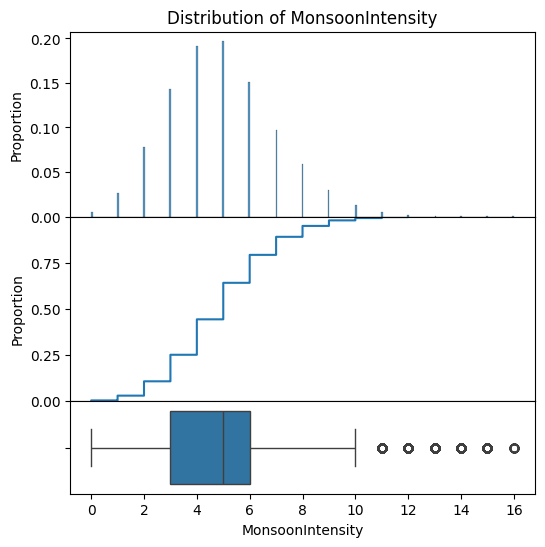

In [40]:
prep = Explorer(train_df)
prep.datatypes()
prep.describe()
prep.distribution('MonsoonIntensity')

<Axes: >

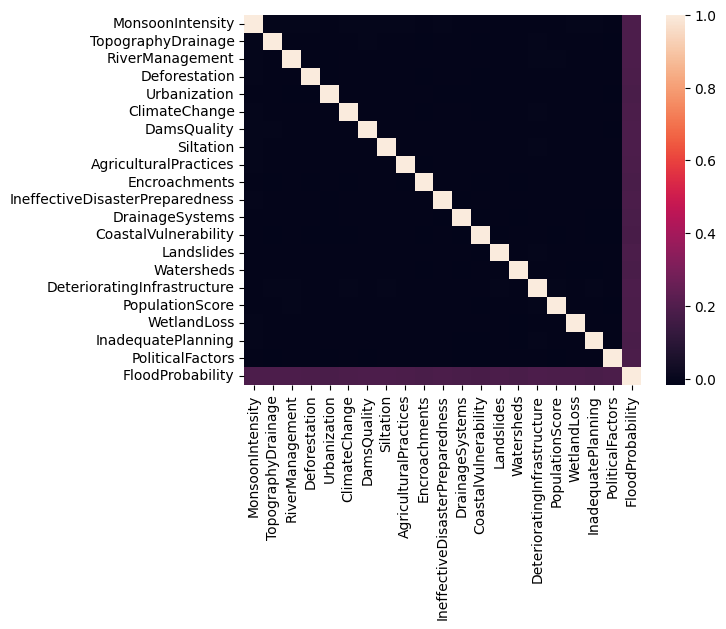

In [41]:
sns.heatmap(train_df.set_index('id').corr())

In [42]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA

X = train_df.drop(columns=['id', 'FloodProbability'])
y = np.array(train_df['FloodProbability'])
y = np.log(y / (1 - y)) # logit

pca = PCA().fit(X)
X[[f'PCA {i+1}' for i in range(pca.n_components_)]] = pca.transform(X)

drop_cols = []
X_temp = X.drop(columns=drop_cols)

lgb = LGBMRegressor()
lgb.fit(X_temp, y)
print(lgb.score(X_temp, y))

xgb = XGBRegressor()
xgb.fit(X_temp, y)
print(xgb.score(X_temp, y))

importances = lgb.feature_importances_
args = np.argsort(importances)
Xcols = np.array(X_temp.columns)[args]
importances.sort()
for (importance, col) in zip(importances[::-1], Xcols[::-1]):
    print(f'{col} : {importance}')

importances = xgb.feature_importances_
args = np.argsort(importances)
Xcols = np.array(X_temp.columns)[args]
importances.sort()
for (importance, col) in zip(importances[::-1], Xcols[::-1]):
    print(f'{col} : {importance}')

0.8632323124864597
0.8665139009906297
PCA 20 : 1084
DeterioratingInfrastructure : 208
MonsoonIntensity : 157
PCA 10 : 145
PCA 1 : 102
DamsQuality : 96
CoastalVulnerability : 94
PCA 19 : 94
TopographyDrainage : 92
PCA 3 : 91
Siltation : 90
PCA 7 : 79
Encroachments : 67
PCA 4 : 67
PCA 5 : 59
PCA 17 : 44
RiverManagement : 43
IneffectiveDisasterPreparedness : 38
InadequatePlanning : 36
Deforestation : 30
PCA 15 : 28
DrainageSystems : 27
PCA 13 : 27
PCA 16 : 24
WetlandLoss : 21
AgriculturalPractices : 21
Urbanization : 20
PCA 18 : 18
Landslides : 17
PCA 12 : 14
PopulationScore : 13
ClimateChange : 10
PoliticalFactors : 9
Watersheds : 9
PCA 11 : 9
PCA 2 : 5
PCA 6 : 4
PCA 8 : 4
PCA 14 : 2
PCA 9 : 2
PCA 20 : 0.9075216054916382
DeterioratingInfrastructure : 0.010265160351991653
CoastalVulnerability : 0.006017841398715973
MonsoonIntensity : 0.005164722446352243
PCA 10 : 0.005070778541266918
PCA 1 : 0.005066504701972008
DamsQuality : 0.00477872509509325
Encroachments : 0.0043983375653624535
Silta

In [48]:
from sklearn.linear_model import LinearRegression

X = train_df.drop(columns=['id', 'FloodProbability'])
y = np.array(train_df['FloodProbability'])
y = np.log(y / (1 - y))  # logit

cols = list(X.columns)

pca = PCA().fit(X)
X[[f'PCA {i+1}' for i in range(pca.n_components_)]] = pca.transform(X)

iters = 20

for iter in range(iters):
    linear = LinearRegression().fit(X, y)
    preds = linear.predict(X)
    print(linear.score(X, y))

    y_new = np.array(y) - np.array(preds)

    X_temp = pd.DataFrame()
    for col in cols:
        min = np.min(X[col])
        X_temp[col] = np.log(X[col] - min + 1)

    linear2 = LinearRegression().fit(X_temp, y_new)
    coefs = linear2.coef_
    print(coefs)

    new_feat = np.ones(y.shape[0])
    for i, col in enumerate(cols):
        new_feat *= (X[col] - np.min(X[col]) + 1)**(coefs[i])
    X[f'Feature {iter+1}'] = new_feat

0.8461556422368847
[ 0.00030705  0.00010931  0.00023342  0.00032971 -0.00044516  0.00038859
  0.00018611  0.00082602  0.00058296  0.00029378  0.00070803  0.00043896
  0.00010436 -0.0002585  -0.00070956  0.00065633  0.00051354  0.00085037
  0.00032979  0.0001405 ]
0.8461797879438178
[ 1.82088661e-04  4.11536607e-05  1.15067685e-04  2.15310590e-04
 -3.87125773e-04  1.13212722e-04 -6.71569978e-05  7.01831429e-04
  2.82677692e-04  1.85278470e-04  4.33331602e-04  4.06607951e-05
 -8.47153014e-05  2.70847349e-06 -1.83950666e-04  5.13744912e-04
  1.23886902e-04  4.41195890e-04  2.17982387e-04  2.07216276e-04]
0.84617990634861
[ 1.51031275e-04  9.25580184e-05  2.94188754e-04  2.23549909e-04
 -4.47263389e-04  1.64461447e-04  2.27960804e-04  5.06510652e-04
  2.75727983e-04  1.87625393e-04  3.07601801e-04  1.89114564e-04
  2.31556499e-05 -2.60781251e-04 -1.91032947e-04  3.37409318e-04
  1.91748050e-04  5.79459104e-04  2.07737999e-04  9.43299374e-05]
0.8461795147513523
[ 1.61365812e-04  5.66983320e

In [49]:
from xgboost import XGBRegressor

drop_cols=[]
X_temp = X.drop(columns=drop_cols)
xgb = XGBRegressor(n_estimators=500,
                   learning_rate=0.05,
                   subsample=0.1)

xgb.fit(X_temp, y)
print(xgb.score(X_temp,y))

importances = xgb.feature_importances_
args = np.argsort(importances)
Xcols = np.array(X_temp.columns)[args]
importances.sort()
for (importance, col) in zip(importances[::-1], Xcols[::-1]):
    print(f'{col} : {importance}')

0.8646290647136744
PCA 20 : 0.7634721398353577
DeterioratingInfrastructure : 0.007994196377694607
Feature 2 : 0.006607902701944113
PCA 1 : 0.006525288801640272
PCA 10 : 0.006001627072691917
CoastalVulnerability : 0.005966114811599255
PCA 19 : 0.005554172210395336
Encroachments : 0.005251763854175806
PCA 3 : 0.0048386408016085625
DamsQuality : 0.004830735269933939
PCA 18 : 0.004682168364524841
Feature 5 : 0.0046371761709451675
InadequatePlanning : 0.004634698387235403
Feature 20 : 0.004513154737651348
PCA 4 : 0.004401028621941805
IneffectiveDisasterPreparedness : 0.004353244323283434
Siltation : 0.00432299030944705
DrainageSystems : 0.004279451910406351
PCA 7 : 0.00419533159583807
PCA 15 : 0.004191041458398104
Feature 8 : 0.004109316971153021
Feature 9 : 0.00400135014206171
Feature 3 : 0.0039903647266328335
Feature 7 : 0.003955948632210493
WetlandLoss : 0.003929590340703726
Feature 13 : 0.0038204051088541746
Feature 4 : 0.003816502634435892
Feature 1 : 0.003804924665018916
PCA 5 : 0.003